# **1. IMPORT MODULES**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import argmax

import string 
import nltk
import re

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

from copy import deepcopy
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin

from joblib import parallel_backend

from sklearn.svm import SVC

from skopt import BayesSearchCV

from sklearn.calibration import CalibratedClassifierCV,calibration_curve

from sklearn.metrics import confusion_matrix,f1_score,classification_report,precision_recall_curve

# **2. DATA**

In [2]:
df = pd.read_csv("./train.csv") # load data
df.info()                       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [3]:
df.drop("id",axis = 1,inplace=True) # Drop id column

In [4]:
df = df.drop_duplicates() # Drop all duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29530 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   29530 non-null  int64 
 1   tweet   29530 non-null  object
dtypes: int64(1), object(1)
memory usage: 692.1+ KB


In [5]:
X = df.iloc[:,1:] # tweets
y = df.iloc[:,:1] # labels

In [6]:
# Split data into:
# 60% - train set      - used to train data
# 20% - validation set - validate models
# 20% - test set       - final test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# **3. DATA PREPROCESSOR**

In [7]:
"""
    Custom transformer
    Expand dataframe with new features which may have sentimental value.
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class FeaturesExpander(BaseEstimator, TransformerMixin):
    """
        @Param [TEXT_COL] - Column containing tweets
    """
    def __init__(self,TEXT_COL):
        self.__wordstop = stopwords.words("english")
        self.__WHITESPACE = " "
        self.TEXT_COL = TEXT_COL
    """
        Counting words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __WordCount(self,text):
        return len(text.split(self.__WHITESPACE))
    """
        Counting average word length in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __AvgWordLength(self, text):
        return np.mean([len(word) for word in text.split()])
    """
        Counting stop words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __StopwordsCount(self, text):
        return len([word for word in text.split() if word in self.__wordstop])
    """
        Counting uppercase words in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __UppercaseCount(self, text):    
        return len([word for word in text.split() if word.isupper()])
    """
        Counting numeric in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __NumericCount(self, text):
        return len([word for word in text.split() if word.isdigit()])
    """
        Counting hashtags in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __HashtagCount(self, text):
        return len([word for word in text.split() if word.startswith("#")])
    """
        Counting mentions in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __MentionCount(self, text):
        return len([word for word in text.split() if word.startswith("@")])
    """
        Counting special characters (emojis,unicodechars,etc..) in tweet
        @Param [text] - tweet
        @Return       - New feature
    """
    def __SpecialCount(selft,text):
        R = "[\u0080-\uFFFF]+" # match any UTF-8 character not in the range of the first 128 characters
        return len([word for word in re.findall(R,text)])
    """
        Expand dataframe with new features 
        @Param [df] - dataframe
        @Return     - New dataframe with new features
    """
    def __Expand(self,df):
        df["Words"] = df[self.TEXT_COL].apply(self.__WordCount)
        df["Avg_Word_Lenght"] = df[self.TEXT_COL].apply(self.__AvgWordLength)
        df["Stopwords"] = df[self.TEXT_COL].apply(self.__StopwordsCount)
        df["Uppercase"] = df[self.TEXT_COL].apply(self.__UppercaseCount)
        df["Numeric"] = df[self.TEXT_COL].apply(self.__NumericCount)
        df["Hashtags"] = df[self.TEXT_COL].apply(self.__HashtagCount)
        df["Mentions"] = df[self.TEXT_COL].apply(self.__MentionCount)
        df["Special_Unicode"] = df[self.TEXT_COL].apply(self.__SpecialCount)
        return df
    """
        Transform data. Expand tweet dataframe with new features.
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with new features
    """
    def transform(self, X, y = None):
        return self.__Expand(X.copy()) 
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """
    def fit(self, X, y = None):
        return self

In [8]:
"""
    Custom transformer
    Clean text.
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.__Lemmatizer = WordNetLemmatizer()
        self.__wordstop = stopwords.words("english")
        self.__Spell = Speller()
        self.__WHITESPACE = " "
        self.__EMPTY_STRING = ""
    """
        Clean text to words only
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __CleanText(self, text):
        REGEX = [
            "\n\t",                  # new lines, tabs 
            "https?://\S+|www\.\S+", # URL = http,https,www #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
            "@[\w\-]+",              # MENTION = Tweet mention
            "<.*?>+|\[.*?\]",        # ATTRIBUTES = <zero or more characters> or [zero or more character]
            "\w*\d\w*"               # NUMBERS = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
        ]  
        for R in REGEX: 
            text = re.sub(R, self.__EMPTY_STRING, text)

        return text.strip().encode("ascii", "ignore").decode("ascii") # Remove emojis and strip text
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __Lemmatize(self, text):
        lemmatized = [self.__Lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
        return self.__WHITESPACE.join(lemmatized) 
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __RemStopwords(self, text):
        noStopwords = [word for word in nltk.word_tokenize(text) if not word in self.__wordstop]
        return self.__WHITESPACE.join(noStopwords) 
    """
        Correct the spelling of the word.
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __Autocorrect(self, text):  
        spells = [self.__Spell(word) for word in (nltk.word_tokenize(text))]
        return self.__WHITESPACE.join(spells) 
    """
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __RemPunctuation(self, text):
        REGEX_PUNCTUATION = "[%s]" # any punctuation
        return re.sub(REGEX_PUNCTUATION % re.escape(string.punctuation),self.__EMPTY_STRING, text)
    """
        Clean tweets to bag of words
        @Param [text] - tweet
        @Return       - Cleaned tweet
    """
    def __SimpleClean(self,text):
        text = text.lower() 
        sentenceToken = nltk.sent_tokenize(text)
        words = []
        for sentence in sentenceToken:
            cleaned = self.__CleanText(sentence)
            corrected = self.__Autocorrect(cleaned)
            noStopwords = self.__RemStopwords(corrected)
            noPunct = self.__RemPunctuation(noStopwords)
            lemmatizzed = self.__Lemmatize(noPunct)

            wordToken = nltk.word_tokenize(lemmatizzed)
            for word in wordToken:
                words.append(word)

        return self.__WHITESPACE.join(words)
    """
        Transform data. Clean tweets
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with cleaned tweet
    """
    def transform(self, X, y = None):
        return X.copy().apply(self.__SimpleClean)
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """  
    def fit(self, X, y = None):
        return self

In [9]:
"""
    Custom transformer
    Remove most frequent and most rare words
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class FrequentWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.__WORDS_MAX = 10 # Delete top 10 frequent words
        self.__WORDS_MIN = 0 
        self.__WORDS_MIN_PERCENTAGE = 0.75 # Delete 75% od rare words
        self.__WHITESPACE = " "
        self.__most = []
        self.__rare = []
    """
        Remove most frequent and most rare words, if tweet is empty after removal don"t remove words from tweet
        @Param [source] - tweet
        @Param [source] - words to delete
        @Return         - modified tweet or previous tweet
    """
    def __RemWords(self, source, words):
        removed = []
        for sentence in source:
            newSentence = []
            for word in sentence.split():
                if word not in words:
                    newSentence.append(word)
            if len(newSentence) == 0:
                removed.append(sentence)
            else:
                removed.append(self.__WHITESPACE.join(newSentence))
        return removed
    """
        Extract most rare words 
        @Param [frequent] - all words with frequency
        @Return           - most rare words
    """
    def __GetWordsMin(self,frequent):
        rareLen = len(frequent[frequent == 1])
        return int(self.__WORDS_MIN_PERCENTAGE * rareLen)
    """
        Handles removing words
        @Param [tweet] 
        @Return        - new tweet
    """
    def __Remove(self,tweet):
        frequent = pd.Series(self.__WHITESPACE.join(tweet).split()).value_counts()
        self.__most = frequent[:self.__WORDS_MAX]

        self.__WORDS_MIN = self.__GetWordsMin(frequent)
        self.__rare = frequent[-1 * self.__WORDS_MIN:]

        tweet = self.__RemWords(tweet,list(self.__most.index)) 
        tweet = self.__RemWords(tweet,list(self.__rare.index))

        return tweet
    """
        Transform data. Remove frequent words
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - New dataframe with cleaned tweet
    """
    def transform(self, X, y = None):
        return self.__Remove(X.copy())
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """   
    def fit(self, X, y = None):
        return self
    """
        Show most rare and most frequent words
    """
    def Show(self):
        print("{0} Most Frequent Words:".format(self.__WORDS_MAX))
        print(self.__most,"\n")
        print("{0} ({1} %) Most Rare Words:".format(self.__WORDS_MIN,self.__WORDS_MIN_PERCENTAGE*100))
        print(self.__rare)

# **4. PREPROCESSING PIPELINE**

In [10]:
"""
    Custom transformer
    Select only specified column
    Custom transformers will inherit pre-existing methods from BaseEstimator and TransformerMixin classes.
"""
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    """
        Transform data. Select only specified column
        @Param [data_dict] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Specified tweet
    """
    def transform(self, data_dict,y=None):
        return data_dict[self.key]
    """
        @Param [X] - tweet dataframe
        @Param [y] - Default: None
                   - label column
        @Return    - Itself
    """  
    def fit(self, x, y=None):
        return self

textPreprocessing = Pipeline([                         # Tweet preprocessing pipeline
    ("clear",Preprocessor()),                          # Clear text
    ("remFreq",FrequentWords()),                       # Remove frequent words
    ("tfidf",TfidfVectorizer(ngram_range = (1,2)))     # Equivalent to:
                                                       # ("bow", CountVectorizer(ngram_range = (1,2))),   # strings to token integer counts CountVectorizer(min_df=1,max_df=2)
                                                       # ("tfidf", TfidfTransformer()),                   # integer counts to weighted TF-IDF scores
])

numericalPreprocessing = Pipeline([                                 # Numeric preprocessing pipeline
    ("NANs", SimpleImputer(missing_values=np.nan, strategy="mean")) # Deal with nan values
])     

textCol = ["tweet"] # Tweet column
numericalCol = ["Words","Avg_Word_Lenght","Stopwords","Uppercase","Numeric","Hashtags","Mentions","Special_Unicode"] # Numeric columns

preprocess = FeatureUnion([                              # Put preprocessors in pipeline
    ("text", Pipeline([
        ("selectorTweet", ItemSelector(key=textCol[0])), # Select tweet columns
        ("textPreprocessing", textPreprocessing)         # Text preprocessing pipeline
    ])),
    ("num", Pipeline([                                   
       ("selectorNum", ItemSelector(key=numericalCol)),  # Select numeric columns
       ("numPreprocessing", numericalPreprocessing)      # Preprocess numerics
       ])
    )
])   

preprocessingPip = Pipeline([                   # Create preprocessing pipeline
    ("expander", FeaturesExpander(textCol[0])), # Expand features
    ("preprocess", preprocess)                  # Preprocess features
])

In [11]:
model = Pipeline([
                ("preprocess",preprocessingPip),
                ("clf",SVC(probability=True))
])

# **8. HYPERPARAMETER TUNNING**

In [12]:
"""
    @Param [preprocessPip]
    @Param [x]                  - Tweets to preprocess
    @Param Optional [transform] - Transform model instead fit_transform
    @Return                     - Preprocessed X
"""
def preProcessTweets(preprocessPip,x,transform = False):
    print("Preprocessing tweets...")  
    with parallel_backend("threading", n_jobs=-1):      # Using threading
        if transform:
            return deepcopy(preprocessPip).transform(x) # Deep copy makes sure to not modify preprocessing pipeline
        else:
            return preprocessPip.fit_transform(x)

"""
    Tune best hyperparamters
    @Param [search]   - Tunning algorithm
    @Param [x]        - Validation data features
    @Param [y]        - Validation data label
    @Return           - Search method
"""
def fitSearch(search,x,y):
    with parallel_backend("threading", n_jobs=-1): # Using threading
        search.fit(x, y)
    print("\nBest Score: {0}".format(search.best_score_))
    print("Best Hyperparameters:\n{0}".format(search.best_params_))

    return search

"""
    Compare Randomized search and Bayes search based on neg_brier_score. Return best hyperparameters.
    @Param [modelPip] - Model in pipeline
    @Param [grid]     - Hyperparameters gird
    @Param [x]        - Validation data features
    @Param [y]        - Validation data label
    @Return           - Tunned model in pipeline
"""
def tuneParams(modelPip,grid,x,y): 
    newX = preProcessTweets(clone(modelPip["preprocess"]),x)
    
    bayesSearch = BayesSearchCV(estimator = clone(modelPip["clf"]), 
                                search_spaces = grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42,
                                scoring="neg_brier_score")

    print("\nStarting Bayes Search...")
    bayesSearch = fitSearch(bayesSearch,newX,y) 

    return clone(Pipeline([ # cloning
                ("preprocess",modelPip["preprocess"]),
                ("clf",bayesSearch.best_estimator_)
        ])) 

In [13]:
gridSVC = {
  "C": [0.1, 1, 10, 100, 1000],                  # Penalty
  "kernel": ["linear","rbf","sigmoid","poly"],   # Hyperplane used to separate the data
  "gamma": [1, 0.1 ,0.01, 0.001, 0.0001]         # Tries to exactly fit the training data set
}

gridSVC # Display gird

{'C': [0.1, 1, 10, 100, 1000],
 'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [14]:
# Find best hyperparameters and compare randomized search and Bayes Search
model = tuneParams(model,gridSVC,X_train, y_train["label"])

Preprocessing tweets...

Starting Bayes Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=10.0, gamma=0.1, kernel=sigmoid; total time=  15.5s
[CV] END ..................C=10.0, gamma=0.1, kernel=sigmoid; total time=  14.9s
[CV] END ..................C=10.0, gamma=0.1, kernel=sigmoid; total time=  17.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................C=100.0, gamma=1.0, kernel=poly; total time= 1.6min
[CV] END ....................C=100.0, gamma=1.0, kernel=poly; total time= 1.8min
[CV] END ....................C=100.0, gamma=1.0, kernel=poly; total time=30.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time= 4.4min
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time= 4.9min
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time= 5.6min
Fitting 3 folds for each of 1 candidates, to

C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 2.0min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.9min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  27.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  28.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  27.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................C=1.0, gamma=0.0001, kernel=linear; total time= 3.8min
[CV] END .................C=1.0, gamma=0.0001, kernel=linear; total time= 3.2min
[CV] END .................C=1.0, gamma=0.0001, kernel=linear; total time= 3.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..............C=1000.0, ga

C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.6min


C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min


C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 2.3min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 2.2min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 2.3min


C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................C=100.0, gamma=0.01, kernel=linear; total time= 5.9min
[CV] END .................C=100.0, gamma=0.01, kernel=linear; total time= 6.4min
[CV] END .................C=100.0, gamma=0.01, kernel=linear; total time= 7.4min


C:\Users\Zeus\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.7min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.6min
[CV] END ..................C=1000.0, gamma=0.001, kernel=rbf; total time= 1.5min

Best Score: -0.03132819893791961
Best Hyperparameters:
OrderedDict([('C', 1000.0), ('gamma', 0.001), ('kernel', 'rbf')])


In [15]:
model["clf"]

SVC(C=1000.0, gamma=0.001, probability=True)

# **9. MODEL CALIBRATION**

In [16]:
"""
    Calibrate models based on sigmoid method
    @Param [model]    - Clean model
    @Param [x]        - Training data features
    @Param [y]        - Training data label
    @Return           - Calibrated model
"""
def calibrate(model,x,y):
    model = clone(Pipeline([ # cloning
        ("preprocess",model["preprocess"]),
        ("clf",CalibratedClassifierCV(model["clf"], method="sigmoid", cv=5))
    ]))

    print("Calibrating model...")
    with parallel_backend("threading", n_jobs=-1): # Using threading
        return model.fit(x,y) 

model = calibrate(model,X_train, y_train["label"])

Calibrating model...


In [17]:
# Predict probabilities of true labels on validation data set
probas = model.predict_proba(X_val)[:, 1]

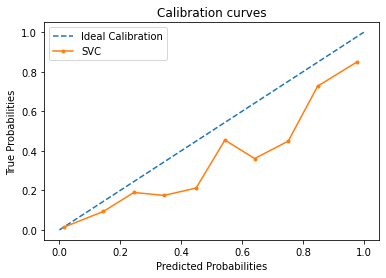

In [18]:
# plot the calibration curve and compare calibration of models
x_p, y_p = calibration_curve(y_val["label"], probas, n_bins=10, normalize="True") 

plt.plot([0, 1], [0, 1],linestyle="--",label="Ideal Calibration")
plt.plot(y_p,x_p,marker=".",label="SVC")
plt.xlabel("Predicted Probabilities")
plt.ylabel("True Probabilities")
plt.title("Calibration curves")
plt.legend()
plt.show()

# **10. THRESHOLD TUNNING**

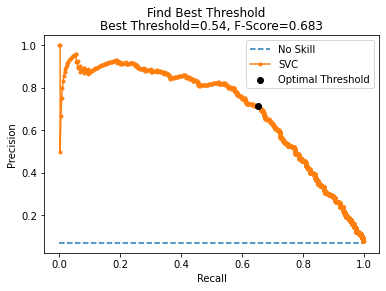

In [19]:
"""
    "Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only"
    Source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    @Param [classifier] - Classifier name
    @Param [proba]      - Probability of being True 
    @Param [y]          - Actual label
    @Return             - Optimal threshold
"""
def tuneThreshold(y,proba,classifier):
    precision, recall, thresholds = precision_recall_curve(y["label"], proba)
    no_skill = len(y.loc[(y["label"] == 1)]) / len(y["label"])
 
    fscore = (2 * precision * recall) / (precision + recall) # convert to f score
    i = argmax(fscore)# locate the index of the largest f score
    
    # plot the roc curve for the model
    plt.plot([0,1], [no_skill,no_skill], linestyle="--", label="No Skill")
    plt.plot(recall, precision, marker=".", label=classifier)
    plt.scatter(recall[i], precision[i], marker="o", color="black", label="Optimal Threshold",zorder=3)

    # axis labels
    plt.suptitle("Find Best Threshold")
    plt.title("Best Threshold={0}, F-Score={1}".format(round(thresholds[i],3), round(fscore[i],3)))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    
    # show the plot
    plt.show()
   
    return thresholds[i]

# Find optimal threshold uing precision-recall curve. Focusing on positive labels as precision is important to us.
thresh = tuneThreshold(y_val,probas,"SVC")

# **11. MODEL SCORE**

In [20]:
# Predict probabilities for labels
with parallel_backend("threading", n_jobs=-1): # Using threading
    probaTest = model.predict_proba(X_test)

In [21]:
# Compare models using brier score
loss = brier_score_loss(y_test["label"], probaTest[:, 1])

print("\nSVC Model:")
print("Brier Loss: {0}".format(loss))


SVC Model:
Brier Loss: 0.03475958167629606


In [22]:
# Apply optimal threshold
predTest = (probaTest [:, 1] >= thresh) 

SVC Results:


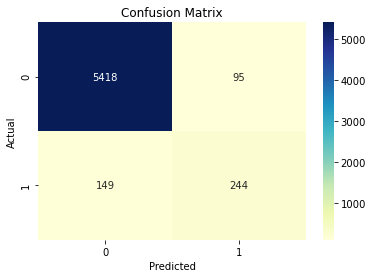

			Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5513
           1       0.72      0.62      0.67       393

    accuracy                           0.96      5906
   macro avg       0.85      0.80      0.82      5906
weighted avg       0.96      0.96      0.96      5906

F1 Score: 0.6666666666666667


In [23]:
"""
    Display confussion matrix, classification report and F1 Score
    @Param [pred]       - Predicted labels
    @Param [y]          - Actual labels
"""
def displayResults(y, pred):
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm,annot=True,cmap="YlGnBu", fmt="d")

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual") 
    plt.show()

    print("\t\t\tClassification Report\n{0}".format(classification_report(y, pred)))
    print("F1 Score: {0}".format(f1_score(y, pred)))

# Display results for SVC
print("SVC Results:")
displayResults(y_test["label"], predTest)